# FTX

In [1]:
!pip install ftx ciso8601 backtrader

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 410 kB 7.2 MB/s 
  Created wheel for ciso8601: filename=ciso8601-2.2.0-cp37-cp37m-linux_x86_64.whl size=37527 sha256=bb75ebdd7dc7f1dd7e725dcd2d0e6e127394329f7dc0bd20b816b7cafa304d81
  Stored in directory: /root/.cache/pip/wheels/ad/25/8f/3b0a82303191efe3c1204f3741c42d8eb2b0236567e22485de
Successfully built ciso8601


In [2]:
import ftx
# import pandas_datareader.data as web
import backtrader as bt
# import numpy as np
from datetime import timezone
from datetime import datetime
from tqdm import tqdm
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
client = ftx.FtxClient(api_key=api, api_secret=secret)
client.get_markets()

[{'ask': 3.9573,
  'baseCurrency': None,
  'bid': 3.9538,
  'change1h': 0.0277705616459708,
  'change24h': 0.10907714734245347,
  'changeBod': 0.07245866088370832,
  'enabled': True,
  'highLeverageFeeExempt': False,
  'last': 3.9563,
  'minProvideSize': 1.0,
  'name': '1INCH-PERP',
  'postOnly': False,
  'price': 3.9563,
  'priceIncrement': 0.0001,
  'quoteCurrency': None,
  'quoteVolume24h': 19512107.0046,
  'restricted': False,
  'sizeIncrement': 1.0,
  'type': 'future',
  'underlying': '1INCH',
  'volumeUsd24h': 19512107.0046},
 {'ask': 4.0038,
  'baseCurrency': None,
  'bid': 3.981,
  'change1h': 0.030410711986610016,
  'change24h': 0.11820264908064607,
  'changeBod': 0.07301638377175342,
  'enabled': True,
  'highLeverageFeeExempt': False,
  'last': 4.0016,
  'minProvideSize': 1.0,
  'name': '1INCH-0924',
  'postOnly': False,
  'price': 4.0016,
  'priceIncrement': 0.0001,
  'quoteCurrency': None,
  'quoteVolume24h': 50270.5225,
  'restricted': False,
  'sizeIncrement': 1.0,
  'ty

In [5]:
def get_df(market_name = 'ALTBULL/USD', resolution = 24*60*60, start = datetime(2015, 10, 19), end = datetime(2021, 5, 19) , limit = 100):

  json_payload_list = client.get_historical_data(market_name = market_name,\
                                                 resolution = resolution, \
                                                 start_time = start.replace(tzinfo=timezone.utc).timestamp(), \
                                                 end_time = end.replace(tzinfo=timezone.utc).timestamp(), \
                                                 limit = limit)

  df = pd.DataFrame()
  for json in tqdm(json_payload_list):
    df2 = pd.json_normalize(json)
    df = df.append(df2, ignore_index = False, sort = True)

  df['startTime'] = pd.to_datetime(df['startTime'])

  df.index = df['startTime']
  df = df['close'].to_frame("close")

  return df

In [29]:
main_df = get_df(market_name = 'ALTBULL/USD', resolution = 24*60*60, start = datetime(2015, 10, 19), end = datetime(2021, 5, 19) , limit = 365*5)
hedge_df = get_df(market_name = 'PAXGBULL/USD', resolution = 24*60*60, start = datetime(2015, 10, 19), end = datetime(2021, 5, 19), limit = 365*5)
gold_df = get_df(market_name = 'PAXG/USD', resolution = 24*60*60, start = datetime(2015, 10, 19), end = datetime(2021, 5, 19), limit = 365*5)

100%|██████████| 492/492 [00:01<00:00, 339.86it/s]


<IPython.core.display.Javascript object>

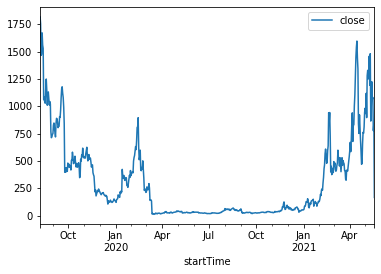

In [30]:
main_df.plot()

<IPython.core.display.Javascript object>

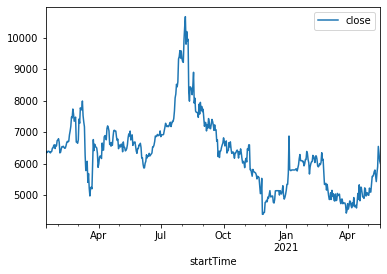

In [31]:
hedge_df.plot()

In [32]:
def prep_for_backtest(crypto_sim):

  for column in ["open", "high", "low"]:
      crypto_sim[column] = crypto_sim["close"]
  crypto_sim["volume"] = 0
  crypto_sim = bt.feeds.PandasData(dataname=crypto_sim) 
  return crypto_sim

main_df = prep_for_backtest(main_df)
hedge_df = prep_for_backtest(hedge_df)
gold_df = prep_for_backtest(gold_df)

In [33]:
def backtest(datas, strategy, plot=False, starting_balance = 1000.0, **kwargs):
    cerebro = bt.Cerebro()
    for data in datas:
        cerebro.adddata(data)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
    cerebro.addanalyzer(bt.analyzers.Returns)
    cerebro.addanalyzer(bt.analyzers.DrawDown)
    cerebro.addstrategy(strategy, **kwargs)
    cerebro.broker.setcash(starting_balance)
    results = cerebro.run()
    if plot:
        cerebro.plot()
    return (starting_balance,
            results[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
            results[0].analyzers.returns.get_analysis()['rnorm100'],
            results[0].analyzers.sharperatio.get_analysis()['sharperatio'],
            cerebro.broker.getvalue())

# Asset Allocation

In [34]:
class AssetAllocation(bt.Strategy):
    params = (
        ('crypto',0.55),
        ('rebalance', 30) # rebalance monthly
    )
    def __init__(self):
        self.crypto = self.datas[0]
        self.hedge = self.datas[1]
        self.counter = 0
        self.prev_value = 0
        self.prev_allocation = 0

    def next(self):

        # total_value = self.broker.get_value()
        # value = self.broker.get_value(datas=[self.crypto])
        # allocation = value / total_value
        # print(allocation)

        if self.counter % self.params.rebalance == 0:
          self.order_target_percent(self.crypto, target=self.params.crypto)
          self.order_target_percent(self.hedge, target=1-self.params.crypto)

        self.counter += 1

<IPython.core.display.Javascript object>

Starting Balance: 1000000.00
Max Drawdown: 72.77%
CAGR: 0.76%
Sharpe: 0.274
Balance: 1019746.950


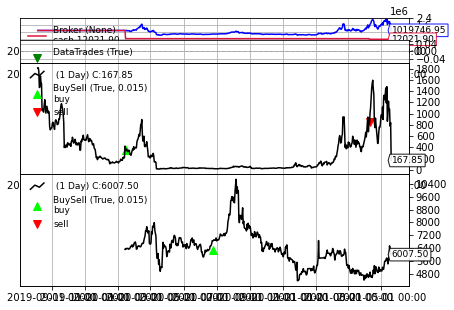

In [35]:
start_balance, dd, cagr, sharpe, final_balance = backtest([main_df, hedge_df], AssetAllocation, plot=True, crypto=0.55, rebalance = 30*3, starting_balance=1000000)
print(f"Starting Balance: {start_balance:.2f}\nMax Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}\nBalance: {final_balance:.3f}")

In [57]:
sharpes = {}
for perc_crypto in range(0, 101, 5):
    sharpes[perc_crypto] = backtest([main_df, hedge_df], AssetAllocation, crypto=(perc_crypto / 100.0), rebalance = 30*3, starting_balance=10000)[3]

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Percent Portfolio Crypto')

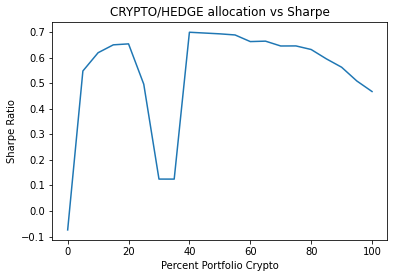

In [58]:
series = pd.Series(sharpes)
ax = series.plot(title="CRYPTO/HEDGE allocation vs Sharpe")
ax.set_ylabel("Sharpe Ratio")
ax.set_xlabel("Percent Portfolio Crypto")

In [60]:
start_balance, dd, cagr, sharpe, final_balance = backtest([main_df, hedge_df], AssetAllocation, crypto=(series.idxmax() / 100.0), rebalance = 30*3, starting_balance=10000)
print(f"Starting Balance: {start_balance:.2f}\nMax Drawdown: {dd:.2f}%\nCAGR: {cagr:.2f}%\nSharpe: {sharpe:.3f}\nBalance: {final_balance:.3f}")

Starting Balance: 10000.00
Max Drawdown: 58.03%
CAGR: 77.71%
Sharpe: 0.700
Balance: 44367.360
